# <font color='brown'>**SMS SPAM DETECTION**</font> 

### **Installation**

In [1]:
import sys
sys.path.append('../../')

### **Load SMS Dataset**

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam. We have used **ELMo** embeddings as features to represent sms sentences.


In [2]:
from helper.utils import load_data_to_numpy
import numpy as np
import pandas as pd

X, X_feats, Y = load_data_to_numpy()

df = pd.DataFrame({'SMS TEXT':X})
result = df.head(10)
display(result)

,SMS TEXT
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...\n
2,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro..."
5,FreeMsg Hey there darling it's been 3 week's n...
6,Even my brother is not like to speak with me. ...
7,As per your request 'Melle Melle (Oru Minnamin...
8,WINNER!! As a valued network customer you have...
9,Had your mobile 11 months or more? U R entitle...



### **Representation of class Labels**

<p>All the class labels for which we define labeling functions are encoded in enum and utilized in our next tasks</p>

<p>SPAM dataset contains 2 classes i.e <b><font color='red'>HAM</font></b> and <b><font color='red'>SPAM</font></b> </p>

In [3]:
import enum

# enum to hold the class labels
class ClassLabels(enum.Enum):
    SPAM = 1
    HAM = 0

THRESHOLD = 0.8

During labeling the unlabelled data we lookup for few keywords to assign a class SMS.

<b>Example</b> : *If a message contains apply or buy in it then most probably the message is spam*

In [4]:
trigWord1 = {"free","credit","cheap","apply","buy","attention","shop","sex","soon","now","spam"}
trigWord2 = {"gift","click","new","online","discount","earn","miss","hesitate","exclusive","urgent"}
trigWord3 = {"cash","refund","insurance","money","guaranteed","save","win","teen","weight","hair"}
notFreeWords = {"toll","Toll","freely","call","meet","talk","feedback"}
notFreeSubstring = {"not free","you are","when","wen"}
firstAndSecondPersonWords = {"I","i","u","you","ur","your","our","we","us","youre"}
thirdPersonWords = {"He","he","She","she","they","They","Them","them","their","Their"}

### **Labeling Functions**

#### Labeling functions are helpful for users to assign a class for an instance programatically. ####

These labeling functions are heuristics which might yeild very <b><font color='red'>noisy lables</font></b> (or) <b><font color='red'>abstains</font></b> on many datapoints. Each labeling function is associated with a class and each labeling function can trigger on its corresponding class given an instance. We use **`@labeling_function(name,resources, preprocessor, label)`** decorator for declaring a labeling function. Before labeling an instance we can preprocess instance through preprocessors.

### **Declaration of simple labeling functions**

In [5]:
from spear.labeling import labeling_function, ABSTAIN

class sampleLabels(enum.Enum):
    red = 1
    green = 0

@labeling_function(label=sampleLabels.red,name="SAMPLE_LABELING")
def sample_labeling(x):
    '''A sample labeling function which predicts red when x is "red"
    label=1 argument in decorator indicates that this lf is corresponding to class red'''
    if(x == "red"):
        return sampleLabels.red
    else:
        return ABSTAIN

label, _ = sample_labeling("red")
print(label)

sampleLabels.red


### **Declaration of simple preprocessor functions**


For most of the tasks in NLP, computer vivsion instead of using the raw datapoint we preprocess the datapoint and then label it. Preprocessor functions are used to preprocess an instance before labeling it. We use **`@preprocessor(name,resources)`** decorator to declare a function as preprocessor.

In [6]:
from spear.labeling import preprocessor


@preprocessor(name = "LOWER_CASE")
def convert_to_lower(x):
    return x.lower().strip()

lower = convert_to_lower("RED")
print(lower)

red


### **Declaration of continious scoring functions**

Along with labeling instances with hard labels we aslo provide soft labels ranging from 0-1 for an instance.

We use **`@continuous_scorer(name,resources)`** decorator to declare a function as continious scorer.

In [7]:
from spear.labeling import continuous_scorer

@continuous_scorer(name="INVERSE  SCORER")
def continious(x):
    if x<1:
        return x
    else:
        return 1/x
    

score = continious(5)
print(score)

0.2


### **Few labeling functions to annotate SMS Dataset**

We have used glove embeddings as part of our continuos scorer to assign soft labels (similarity score).

`word_similarity` is a function with `@continuous_scorer(name,resources)` decorator to calculate the similarity with trigger words.

In [14]:
from spear.labeling import labeling_function, ABSTAIN, preprocessor

from helper.con_scorer import word_similarity
import re


@preprocessor()
def convert_to_lower(x):
    return x.lower().strip()


@labeling_function(resources=dict(keywords=trigWord1),pre=[convert_to_lower],label=ClassLabels.SPAM)
def LF1(x,**kwargs):    
    if len(kwargs["keywords"].intersection(x.split())) > 0:
        return ClassLabels.SPAM
    else:
        return ABSTAIN

@labeling_function(resources=dict(keywords=trigWord2),pre=[convert_to_lower],label=ClassLabels.SPAM)
def LF2(x,**kwargs):
    if len(kwargs["keywords"].intersection(x.split())) > 0:
        return ClassLabels.SPAM
    else:
        return ABSTAIN

@labeling_function(resources=dict(keywords=trigWord3),pre=[convert_to_lower],label=ClassLabels.SPAM)
def LF3(x,**kwargs):
    if len(kwargs["keywords"].intersection(x.split())) > 0:
        return ClassLabels.SPAM 
    else:
        return ABSTAIN

@labeling_function(resources=dict(keywords=notFreeWords),pre=[convert_to_lower],label=ClassLabels.HAM)
def LF4(x,**kwargs):
    if "free" in x.split() and len(kwargs["keywords"].intersection(x.split()))>0:
        return ClassLabels.HAM
    else:
        return ABSTAIN

@labeling_function(resources=dict(keywords=notFreeSubstring),pre=[convert_to_lower],label=ClassLabels.HAM)
def LF5(x,**kwargs):
    for pattern in kwargs["keywords"]:    
        if "free" in x.split() and re.search(pattern,x, flags= re.I):
            return ClassLabels.HAM
    return ABSTAIN

@labeling_function(resources=dict(keywords=firstAndSecondPersonWords),pre=[convert_to_lower],label=ClassLabels.HAM)
def LF6(x,**kwargs):
    if "free" in x.split() and len(kwargs["keywords"].intersection(x.split()))>0:
        return ClassLabels.HAM
    else:
        return ABSTAIN


@labeling_function(resources=dict(keywords=thirdPersonWords),pre=[convert_to_lower],label=ClassLabels.HAM)
def LF7(x,**kwargs):
    if "free" in x.split() and len(kwargs["keywords"].intersection(x.split()))>0:
        return ClassLabels.HAM
    else:
        return ABSTAIN

@labeling_function(label=ClassLabels.SPAM)
def LF8(x,**kwargs):
    if (sum(1 for ch in x if ch.isupper()) > 6):
        return ClassLabels.SPAM
    else:
        return ABSTAIN

# @labeling_function()
# def LF9(x,**kwargs):
#     return ClassLabels.HAM.value

@labeling_function(cont_scorer=word_similarity,resources=dict(keywords=trigWord1),pre=[convert_to_lower],label=ClassLabels.SPAM)
def CLF1(x,**kwargs):
    if kwargs["continuous_score"] >= THRESHOLD:
        return ClassLabels.SPAM
    else:
        return ABSTAIN

@labeling_function(cont_scorer=word_similarity,resources=dict(keywords=trigWord2),pre=[convert_to_lower],label=ClassLabels.SPAM)
def CLF2(x,**kwargs):
    if kwargs["continuous_score"] >= THRESHOLD:
        return ClassLabels.SPAM
    else:
        return ABSTAIN

@labeling_function(cont_scorer=word_similarity,resources=dict(keywords=trigWord3),pre=[convert_to_lower],label=ClassLabels.SPAM)
def CLF3(x,**kwargs):
    if kwargs["continuous_score"] >= THRESHOLD:
        return ClassLabels.SPAM
    else:
        return ABSTAIN

@labeling_function(cont_scorer=word_similarity,resources=dict(keywords=notFreeWords),pre=[convert_to_lower],label=ClassLabels.HAM)
def CLF4(x,**kwargs):
    if kwargs["continuous_score"] >= THRESHOLD:
        return ClassLabels.HAM
    else:
        return ABSTAIN

@labeling_function(cont_scorer=word_similarity,resources=dict(keywords=notFreeSubstring),pre=[convert_to_lower],label=ClassLabels.HAM)
def CLF5(x,**kwargs):
    if kwargs["continuous_score"] >= THRESHOLD:
        return ClassLabels.HAM
    else:
        return ABSTAIN

@labeling_function(cont_scorer=word_similarity,resources=dict(keywords=firstAndSecondPersonWords),pre=[convert_to_lower],label=ClassLabels.HAM)
def CLF6(x,**kwargs):
    if kwargs["continuous_score"] >= THRESHOLD:
        return ClassLabels.HAM
    else:
        return ABSTAIN

@labeling_function(cont_scorer=word_similarity,resources=dict(keywords=thirdPersonWords),pre=[convert_to_lower],label=ClassLabels.HAM)
def CLF7(x,**kwargs):
    if kwargs["continuous_score"] >= THRESHOLD:
        return ClassLabels.HAM
    else:
        return ABSTAIN

@labeling_function(cont_scorer=lambda x: 1-np.exp(float(-(sum(1 for ch in x if ch.isupper()))/2)),label=ClassLabels.SPAM)
def CLF8(x,**kwargs):
    if kwargs["continuous_score"] >= THRESHOLD:
        return ClassLabels.SPAM
    else:
        return ABSTAIN

# @labeling_function()
# def CLF9(x,**kwargs):
#     return ClassLabels.HAM


### **LFSet**

Place holder for declared labeling functions. 

In [15]:
from spear.labeling import LFSet

LFS = [LF1,
    LF2,
    LF3,
    LF4,
    LF5,
    LF6,
    LF7,
    LF8,
    CLF1,
    CLF2,
    CLF3,
    CLF4,
    CLF5,
    CLF6,
    CLF7,
    CLF8
      ]

rules = LFSet("SPAM_LF")
rules.add_lf_list(LFS)

### **Label the dataset with defined labeling functions**

We can label the dataset using PreLabels by providing as set of labeling funtions. We can also provide the golden labels of the dataset if we already have some labeled data to evaluate our lf's.We provide both the  <b><font color='blue'>soft labels</font></b> and  <b><font color='blue'>hard labels</font></b> given an instance, although these labels can be very noisy we provide few frameworks to effectively use these rules to label unlabelled data.

In [16]:
from spear.labeling import PreLabels

R = np.zeros((X.shape[0],len(rules.get_lfs())))

sms_noisy_labels = PreLabels(name="sms",
                               data=X,
                               data_feats = X_feats,
                               gold_labels=Y,
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=2)
L,S = sms_noisy_labels.get_labels()

100%|██████████| 5574/5574 [05:52<00:00, 15.83it/s]


### **Analyse and refining labeling functions**

Once we are done with labeling the dataset with given lf's, we can analyse the labeling functions we declared by calculating  <b><font color='blue'>coverage, overlap, conflicts, empirical accuracy</font></b> for of each lf which helps us to re-iterate on the process by refining new lf's.

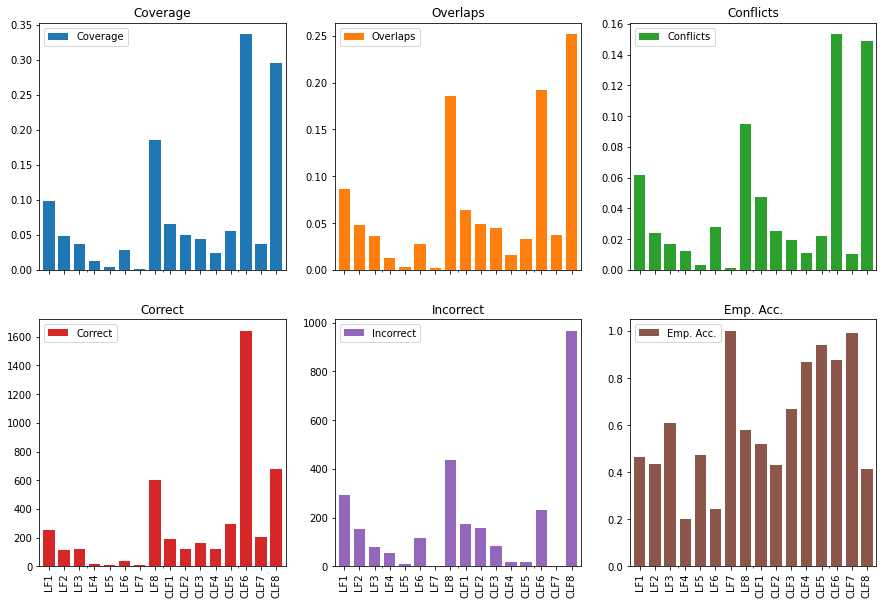

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF1,"[-1.0, 0.0]",0.098134,0.086114,0.061356,253,294,0.462523
LF2,"[-1.0, 0.0]",0.048260,0.048260,0.024220,117,152,0.434944
LF3,"[-1.0, 0.0]",0.036598,0.036598,0.016505,124,80,0.607843
LF4,"[-1.0, 1.0]",0.012379,0.012379,0.012379,14,55,0.202899
LF5,"[-1.0, 1.0]",0.003409,0.003409,0.003409,9,10,0.473684
LF6,"[-1.0, 1.0]",0.027808,0.027808,0.027808,38,117,0.245161
LF7,"[-1.0, 1.0]",0.001435,0.001435,0.001435,8,0,1.000000
LF8,"[-1.0, 0.0]",0.186042,0.186042,0.094546,602,435,0.580521
CLF1,"[-1.0, 0.0]",0.065124,0.064406,0.047542,188,175,0.517906
CLF2,"[-1.0, 0.0]",0.049695,0.049157,0.024937,119,158,0.429603


In [17]:
from spear.labeling import LFAnalysis

analyse = sms_noisy_labels.analyse_lfs(plot=True)

result = analyse.head(16)
display(result)

In [ ]:
sms_noisy_labels.generate_pickle()
sms_noisy_labels.generate_json()